**Импорт**

In [3]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv2D, GlobalAveragePooling2D, Dropout, TimeDistributed

import skvideo.io

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

**Загрузка данных** *(измените значение на 1 перед условным оператором, для загрузки)*

In [5]:
if 0:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip
        
if 0:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

**Функции обработки данных**

In [6]:
def dirs_to_class(dir):
    classes = []
    for root, dirs, filenames in os.walk('./'):
        for dir_name in dirs:
            if not dir_name.startswith('.'):
                classes.append(dir_name)
    return classes

In [7]:
def make_data(dir, ext):
    dataset = []
    data_root = dir
    class_names = dirs_to_class('./')
    for cls in class_names:
        print('Processing class: {}'.format(cls))
        for fpath in glob.glob(os.path.join(data_root, cls, ext)):
            cls_idx = class_names.index(cls)
            dataset.append((fpath, cls_idx))
    return dataset

In [8]:
def write_npy_from_avi(dir):
    for iter, (fpath, label) in enumerate(make_data(dir, '*.avi')):
        videodata = skvideo.io.vread(fpath, num_frames = 204)
        videodata = videodata.astype(np.float32) / 255.
        videodata = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
        name = ("./"+fpath.split('.')[1]+'.npy')
        np.save(name, videodata)
        os.remove(fpath)
    print('Complete!')

**Запуск формирования данных** *(измените значение на 1 перед условным оператором, для загрузки). Осторожно, функции генерируют запись данных на диск, т.к. не помещаются полностью в ОЗУ*:

In [9]:
if 0:
    write_npy_from_avi('./')

In [10]:
NUM_ITEMS = len(glob.glob('*/*.npy'))

In [11]:
NUM_ITEMS

599

**Создание Pipeline**

In [12]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    class_names = dirs_to_class('./')
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

In [13]:
def make_dataset(dir):
    list_ds = tf.data.Dataset.list_files(str(dir+'*/*.npy'))
    list_ds = list_ds.shuffle(NUM_ITEMS)
    
    def read_npy_file(file_path):
        videodata = np.load(file_path.numpy().decode("utf-8"), allow_pickle=True)
        return videodata.astype(np.float32)    
    
    def process_path(file_path):
        #label = tf.strings.split(file_path, os.sep)[-2]
        label = get_label(file_path)
        videodata = tf.py_function(func=read_npy_file, inp=[file_path], Tout=tf.float32)
        return videodata, label
    
    labeled_ds = list_ds.map(process_path)
    labeled_ds = labeled_ds.batch(8)
    
    return labeled_ds

In [14]:
def split_data(data):
    #data = data.shuffle(NUM_ITEMS)
    test = data.take(2) 
    train = data.skip(2) 
    return train, test

In [15]:
data = make_dataset('./')

In [16]:
train, test = split_data(data)

In [17]:
for obj in test.take(1):
    print(obj)

(<tf.Tensor: shape=(8, 203, 120, 160, 1), dtype=float32, numpy=
array([[[[[ 0.        ],
          [ 0.        ],
          [ 0.        ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 0.        ],
          [ 0.        ],
          [ 0.        ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 0.        ],
          [ 0.        ],
          [ 0.        ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         ...,

         [[ 0.        ],
          [ 0.        ],
          [ 0.        ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 0.        ],
          [ 0.        ],
          [ 0.        ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 0.        ],
          [ 0.        ],
          [ 0.        ],
          .

**Модель и обучение**

In [18]:
NUM_EPOCHS = 30
LEARNING_RATE = 0.1
INPUT_SHAPE = (8, 203, 120, 160, 1)

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu', input_shape=INPUT_SHAPE[1:]),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Reshape((-1, 64)),
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

In [18]:
for obj, label_text in test.take(1):
    inp = obj
    out = model(inp)

    print('Input shape:', inp.shape)
    print('Output shape:', out.shape)

Input shape: (8, 203, 120, 160, 1)
Output shape: (8, 6)


In [19]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam())

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 203, 60, 80, 32)   4032      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 203, 30, 40, 32)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 203, 15, 20, 64)   256064    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 203, 8, 10, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 203, 4, 5, 64)     110656    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 203, 2, 3, 64)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 203, 2, 3, 64)     1

In [21]:
epochs=30
history = model.fit(
    train,
    validation_data=test,
    epochs=epochs
    )

Epoch 1/30
73/73 [==============================] - 30s 372ms/step - loss: 1.6929 - val_loss: 1.2130
Epoch 2/30
73/73 [==============================] - 25s 335ms/step - loss: 1.2217 - val_loss: 0.6023
Epoch 3/30
73/73 [==============================] - 25s 337ms/step - loss: 1.0056 - val_loss: 0.6385
Epoch 4/30
73/73 [==============================] - 25s 336ms/step - loss: 0.8471 - val_loss: 0.6073
Epoch 5/30
73/73 [==============================] - 25s 335ms/step - loss: 0.7754 - val_loss: 0.4619
Epoch 6/30
73/73 [==============================] - 24s 333ms/step - loss: 0.6235 - val_loss: 0.4862
Epoch 7/30
73/73 [==============================] - 24s 333ms/step - loss: 0.4644 - val_loss: 0.4447
Epoch 8/30
73/73 [==============================] - 25s 334ms/step - loss: 0.3515 - val_loss: 0.0679
Epoch 9/30
73/73 [==============================] - 25s 342ms/step - loss: 0.3153 - val_loss: 0.5523
Epoch 10/30
73/73 [==============================] - 25s 337ms/step - loss: 0.3577 - val_lo

**Тестируем**

In [28]:
inference = make_data('./', '*.npy')

Processing class: boxing
Processing class: jogging
Processing class: running
Processing class: handwaving
Processing class: walking
Processing class: handclapping


In [29]:
classes = dirs_to_class('./')

True class: boxing
Predicted class: boxing


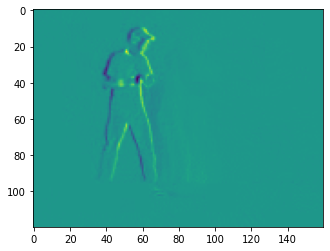

In [51]:
fpath, cls_true = random.choice(inference)

videodata = np.load(fpath, allow_pickle=True)
plt.imshow(videodata[30, ...])

out = model.predict(videodata[None, ...])
cls_pred = np.argmax(out)

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])